<center><h1>Data 245: Project</h1>
    <h2>NBA Prediction</h2>

<h3>Imports

In [1]:
import numpy as np, scipy as sc, pandas as pd, requests
import xml.etree.ElementTree as ET
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats, playergamelog, playergamelogs, fantasywidget
from nba_api.stats.endpoints import infographicfanduelplayer, playerdashboardbylastngames, playernextngames
from nba_api.stats.endpoints import commonplayerinfo, commonallplayers
import json
import time
from IPython.display import Audio
from pulp import *
import inspect
import os

<h3>Notes

Scoring Rules:
- point +1
- 3pt made +0.5
- rebound +1.25
- assist +1.5
- steal +2
- turnover -0.5
- 10x2 +1.5
- 10x3 +3

Gen restrictions:
- 8 players
- min 2 teams
- 1x5 basic positions, 1G, 1F, 1 Util

<h3>Sound (not neccessary for function)

In [2]:
'''
Audio Source:
https://mixkit.co/free-sound-effects/beep/
Positive Interface Beep
'''
sound_file = './sound/beep.wav'

<h3>Injuries Dataframe

<h3>Get Active Players

In [3]:
x = commonallplayers.CommonAllPlayers().get_data_frames()[0]

In [4]:
active_players = x[x['TO_YEAR'] == '2020']

In [5]:
ap = list(active_players['PERSON_ID'])

In [6]:
len(ap)

541

<h3>Team Stats DF

In [7]:
from nba_api.stats.static import teams
# get_teams returns a list of 30 dictionaries, each an NBA team.
nba_teams = teams.get_teams()

In [8]:
nba_teams[0]

{'id': 1610612737,
 'full_name': 'Atlanta Hawks',
 'abbreviation': 'ATL',
 'nickname': 'Hawks',
 'city': 'Atlanta',
 'state': 'Atlanta',
 'year_founded': 1949}

In [9]:
t_id_list = [i['id'] for i in nba_teams]

In [10]:
# Data mining code from https://github.com/billyhansen6/DraftKingsPredictions/blob/master/Basketball%20Project%20Data%20Downloads%20and%20Dump%20into%20SQL.ipynb
# minor modifications made
url = 'http://www.espn.com/nba/hollinger/teamstats'
html = requests.get(url).content
df_list = pd.read_html(html)
team_stats = df_list[-1]
team_stats = team_stats.drop(0, 1)
team_stats = team_stats.drop(0, 0)
team_stats = team_stats.drop(1, 0)
team_stats = team_stats.rename(columns={1: "TEAM", 
                                                    2:'PACE',
                                                    3: 'AST',
                                                    4: 'TURN_OVERS',
                                                    5: 'OFF_RATING',
                                                    6: 'DEF_RATING',
                                                    7: 'REBOUND_EFF',
                                                    8: 'EFF',
                                                    9: 'TS',
                                                    10: 'OFF_EFF',
                                                    11: 'DEF_EFF'})

In [11]:
team_dic = {'OKC': 'Oklahoma City', 'BRK': 'Brooklyn','MIA': 'Miami','ORL': 'Orlando',
                'MIN': 'Minnesota', 'SAS': 'San Antonio', 'BOS': 'Boston', 'NOP': 'New Orleans',
                'POR': 'Portland', 'PHI': 'Philadelphia', 'HOU': 'Houston', 'IND': 'Indiana',
                'MIL': 'Milwaukee', 'TOR': 'Toronto', 'CHI': 'Chicago', 'DEN': 'Denver',
                'ATL': 'Atlanta', 'CHO': 'Charlotte', 'NYK': 'New York', 'LAL': 'LA Lakers',
                'DAL': 'Dallas', 'WAS': 'Washington', 'GSW': 'Golden State', 'LAC': 'LA Clippers', 
                'PHO': 'Phoenix', 'SAC': 'Sacramento', 'DET': 'Detroit', 'UTA': 'Utah',
                'MEM': 'Memphis','CLE': 'Cleveland'}

In [12]:
inv_map = {v: k for k, v in team_dic.items()}

In [13]:
team_stats = team_stats.replace({'TEAM':inv_map})

<h3>Gamelog Dictionary

In [14]:
Game_Logs = {}

In [15]:
e = 0
for player in ap:
    try:
        base = playergamelog.PlayerGameLog(player_id=player, timeout=1000).get_data_frames()
        Game_Logs[player] = base[0]
        time.sleep(0.600)
    except:
        if e < 7:
            e+=1
            time.sleep(45)
            #print(e)
            base = playergamelog.PlayerGameLog(player_id=player, timeout=1000).get_data_frames()
            Game_Logs[player] = base[0]
            continue
        else:
            print('break')
            break
Audio(sound_file, autoplay=True)

ValueError: rate must be specified when data is a numpy array or list of audio samples.

<h3>Final Data Frame Creation

In [16]:
for player in ap:
    if len(Game_Logs[player]) == 0:
        Game_Logs.pop(player)

In [17]:
def dkings_score(row):
    try:
        threes = row['FG3M']
        r = row['REB']
        a = row['AST']
        s = row['STL']
        b = row['BLK']
        t = row['TOV']
        p = row['PTS']
        score = 0.5*threes + 1.25*r + 1.5*a + 2*s +2*b + -0.5*t + p
        dd = sum(1 for i in [p, r, a, s, b] if i>=10)
        if dd == 2:
            score += 1.5
        if dd > 2:
            score += 4.5
        return(score)
    except:
        print(row)
        pass

In [18]:
# Add rest days into dataframe

def resting(select_df):
    
    # Transform string of game_date to datetime format

    select_df['GAME_DATETIME'] = pd.to_datetime(select_df['GAME_DATE'], format='%b %d, %Y')
    select_df['GAME_DATENEW'] = select_df['GAME_DATETIME'].dt.date
    
    # Take diff between each date

    select_df['GAME_DATENEW']=pd.to_datetime(select_df['GAME_DATENEW'])
    select_df['REST_DAYS'] = select_df['GAME_DATENEW'].diff()
    
    # Rest days column is added

    select_df['REST_DAYS'] = select_df['REST_DAYS'].abs()

In [19]:
to_be_averaged= ['MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA',
       'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TOV',
       'PTS']

In [20]:
for frame in Game_Logs:
    x = Game_Logs[frame].reindex(index = Game_Logs[frame].index[::-1])
    x['DKING_SCORE'] = x.apply(lambda row: dkings_score(row), axis=1)
    x['TEAM'] = x.apply(lambda row: row['MATCHUP'][:3], axis=1)
    x['OPPOSING_TEAM'] = x.apply(lambda row: row['MATCHUP'][-3:], axis=1)
    x['HOME_AWAY'] = x.apply(lambda row: 1 if '@' in row['MATCHUP'] else 0, axis = 1)
    x.rename({'WL': 'PREVIOUS_WL'})
    for column in to_be_averaged:
        x['SEASON_'+ column] = x[column].rolling(window = len(x), min_periods = 1).mean()
        x['5_GAME_AVG_'+ column] = x[column].rolling(window = 5, min_periods = 1).mean()
    Game_Logs[frame] = x.drop(['MIN', 'MATCHUP', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'], axis = 1)

In [21]:
not_shift = ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE','DKING_SCORE',
       'TEAM', 'OPPOSING_TEAM', 'HOME_AWAY']

In [22]:
testing = Game_Logs[ap[0]]

In [23]:
to_shift = [i for i in testing.columns if i not in not_shift]

In [24]:
# Create new dataframe predict for testing our models
# Lists the latest game that each player played in and their stats

predict = {}

for frame in Game_Logs:
    for column in to_shift:
        Game_Logs[frame][column]= Game_Logs[frame][column].shift(1)
    resting(Game_Logs[frame])
    Game_Logs[frame] = Game_Logs[frame][[c for c in Game_Logs[frame] if c != 'DKING_SCORE'] 
       + ['DKING_SCORE']]
    predict[frame] = Game_Logs[frame].iloc[-1]

predict_df = pd.DataFrame(predict).T
predict_df = predict_df.drop(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'GAME_DATETIME', 'GAME_DATENEW'], axis = 1)

# Drop players who have NaN in WL as they are injured and currently cannot be any lineup
predict_df = predict_df.dropna()

In [25]:
predict_df['PERSON_ID'] = predict_df.index
predict_df

,WL,TEAM,OPPOSING_TEAM,HOME_AWAY,SEASON_MIN,5_GAME_AVG_MIN,SEASON_FGM,5_GAME_AVG_FGM,SEASON_FGA,5_GAME_AVG_FGA,...,5_GAME_AVG_STL,SEASON_BLK,5_GAME_AVG_BLK,SEASON_TOV,5_GAME_AVG_TOV,SEASON_PTS,5_GAME_AVG_PTS,REST_DAYS,DKING_SCORE,PERSON_ID
1630173,W,MIA,DAL,0,12.0175,9.8,1.96491,0.8,3.64912,2.8,...,0.2,0.45614,0,0.719298,0.6,4.85965,1.8,2 days,6.75,1630173
1629121,L,MIL,TOR,0,3,3.4,0.166667,0.2,1.33333,1.4,...,0,0,0,0,0,0.333333,0.4,6 days,0,1629121
203500,L,NOP,GSW,0,27.7895,25.2,3.31579,3.2,5.35088,5,...,1,0.649123,0.4,1.36842,1,7.66667,7,6 days,16,203500
1628389,W,MIA,DAL,0,33.4828,34.2,7.24138,7.6,12.7241,12.8,...,2,1.05172,0.4,2.65517,1.4,19.069,19.4,2 days,42.75,1628389
200746,W,BKN,LAL,0,26,24.6,5.4,4,11.52,8.6,...,0.6,1.04,1.6,1,1.4,13.6,10.8,3 days,23.75,200746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626153,W,SAC,IND,1,27.0357,28.6,3.55357,4.6,7.78571,10.6,...,1.8,0.482143,1.2,1.19643,2,9.73214,10.6,1 days,55.25,1626153
201152,L,CHI,CHA,1,24.2787,27,5.52459,5.6,9.62295,10.4,...,1,0.540984,0.2,1.98361,1.8,12.1803,12.2,3 days,31.5,201152
1629027,W,ATL,IND,1,34.0172,31,7.65517,7.4,17.6379,15.6,...,1.4,0.189655,0,4.18966,3.2,25.2931,24.4,1 days,52.5,1629027
203469,W,CHA,CHI,0,20.3659,13,3.60976,3.4,6.60976,5.4,...,0,0.365854,0.2,1.02439,1.2,9,8.6,2 days,22.25,203469


In [26]:
predict_df['REST_DAYS'] = predict_df.apply(lambda row: row['REST_DAYS'].days, axis=1)
predict_df = pd.merge(predict_df, team_stats[['TEAM','PACE']], on = 'TEAM')
predict_df = pd.merge(predict_df, team_stats[['TEAM','PACE', 'TURN_OVERS', 'DEF_RATING']], left_on = 'OPPOSING_TEAM',
                   right_on = 'TEAM')
predict_df = predict_df.drop(['TEAM_x', 'OPPOSING_TEAM', 'TEAM_y'], axis = 1)

In [27]:
predict_df = predict_df[[c for c in predict_df.columns if c != 'DKING_SCORE'] 
       + ['DKING_SCORE']]
predict_df['WL'] = predict_df['WL'].astype('category').cat.codes
predict_df.head()

# We will use the predict dataframe further down for testing our models

,WL,HOME_AWAY,SEASON_MIN,5_GAME_AVG_MIN,SEASON_FGM,5_GAME_AVG_FGM,SEASON_FGA,5_GAME_AVG_FGA,SEASON_FG3M,5_GAME_AVG_FG3M,...,5_GAME_AVG_TOV,SEASON_PTS,5_GAME_AVG_PTS,REST_DAYS,PERSON_ID,PACE_x,PACE_y,TURN_OVERS,DEF_RATING,DKING_SCORE
0,1,0,12.0175,9.8,1.96491,0.8,3.64912,2.8,0,0,...,0.6,4.85965,1.8,2,1630173,98.6,99.5,11.2,77.8,6.75
1,1,0,33.4828,34.2,7.24138,7.6,12.7241,12.8,0.0344828,0,...,1.4,19.069,19.4,2,1628389,98.6,99.5,11.2,77.8,42.75
2,1,0,27.25,28.8,3.08333,3.8,7.58333,8.8,1.58333,1.6,...,1,8.91667,10.6,2,2772,98.6,99.5,11.2,77.8,27.5
3,1,0,13.3,13.2,3.2,3.6,4.4,4.6,0,0,...,0.8,8.3,9.2,2,203473,98.6,99.5,11.2,77.8,20
4,1,0,26.6818,28,4.65909,4.2,10.7727,10.4,1.63636,1.4,...,1.6,13,11.2,2,201609,98.6,99.5,11.2,77.8,31.25


In [28]:
for frame in Game_Logs:
    for column in to_shift:
        Game_Logs[frame][column]= Game_Logs[frame][column].shift(1)
    resting(Game_Logs[frame])
    Game_Logs[frame] = Game_Logs[frame][[c for c in Game_Logs[frame] if c != 'DKING_SCORE'] 
       + ['DKING_SCORE']]
    Game_Logs[frame] = Game_Logs[frame].iloc[1:]

In [29]:
final_df = pd.concat(Game_Logs, axis= 0)
final_df = final_df.drop(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'GAME_DATETIME', 'GAME_DATENEW'], axis = 1)

In [30]:
final_df['REST_DAYS'] = final_df.apply(lambda row: row['REST_DAYS'].days, axis=1)

In [31]:
final_df = pd.merge(final_df, team_stats[['TEAM','PACE']], on = 'TEAM')

In [32]:
final_df = pd.merge(final_df, team_stats[['TEAM','PACE', 'TURN_OVERS', 'DEF_RATING']], left_on = 'OPPOSING_TEAM',
                   right_on = 'TEAM')

In [33]:
final_df = final_df.drop(['TEAM_x', 'OPPOSING_TEAM', 'TEAM_y'], axis = 1)

In [34]:
final_df = final_df[[c for c in final_df.columns if c != 'DKING_SCORE'] 
       + ['DKING_SCORE']]

In [35]:
final_df['WL'] = final_df['WL'].astype('category').cat.codes

In [36]:
# Drop all NaNs
final_df = final_df.dropna()
final_df

,WL,HOME_AWAY,SEASON_MIN,5_GAME_AVG_MIN,SEASON_FGM,5_GAME_AVG_FGM,SEASON_FGA,5_GAME_AVG_FGA,SEASON_FG3M,5_GAME_AVG_FG3M,...,SEASON_TOV,5_GAME_AVG_TOV,SEASON_PTS,5_GAME_AVG_PTS,REST_DAYS,PACE_x,PACE_y,TURN_OVERS,DEF_RATING,DKING_SCORE
1,1,1,13.878788,10.2,2.393939,1.4,4.121212,2.8,0.000000,0.0,...,0.969697,0.6,6.121212,4.2,2,98.6,102.1,12.8,80.0,16.25
4,1,1,33.000000,34.6,6.050000,6.2,13.950000,15.0,0.350000,0.8,...,2.250000,3.2,19.500000,18.4,6,98.6,102.1,12.8,80.0,51.25
6,1,1,26.850000,26.8,5.350000,5.2,11.750000,11.6,1.700000,1.6,...,2.900000,3.0,14.900000,14.6,2,98.6,102.1,12.8,80.0,24.00
9,1,1,33.043478,31.0,6.391304,6.4,14.217391,13.4,2.043478,2.2,...,2.608696,2.4,16.739130,16.8,2,98.6,102.1,12.8,80.0,6.00
11,1,1,21.593750,23.4,1.718750,2.4,4.312500,4.4,1.156250,2.0,...,1.093750,1.6,4.812500,7.2,2,98.6,102.1,12.8,80.0,18.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16768,1,1,34.571429,34.6,9.428571,9.0,20.857143,19.2,3.142857,2.8,...,2.428571,2.4,24.285714,24.0,2,100.7,98.6,13.2,77.0,42.75
16769,1,1,22.000000,21.2,3.142857,3.4,5.857143,6.0,0.428571,0.2,...,1.142857,1.4,7.000000,7.4,2,100.7,98.6,13.2,77.0,22.75
16770,1,1,24.166667,24.6,4.000000,3.6,7.666667,7.2,0.000000,0.0,...,1.500000,1.8,9.666667,9.2,2,100.7,98.6,13.2,77.0,18.75
16771,0,1,17.000000,17.4,1.833333,2.0,4.000000,3.8,0.500000,0.4,...,0.500000,0.4,4.333333,4.6,2,100.7,98.6,13.2,77.0,20.00


<h3>Forecast Model Training

In [37]:
from sklearn import metrics

In [38]:
y = final_df['DKING_SCORE']
X = final_df.drop(columns = ['DKING_SCORE'])

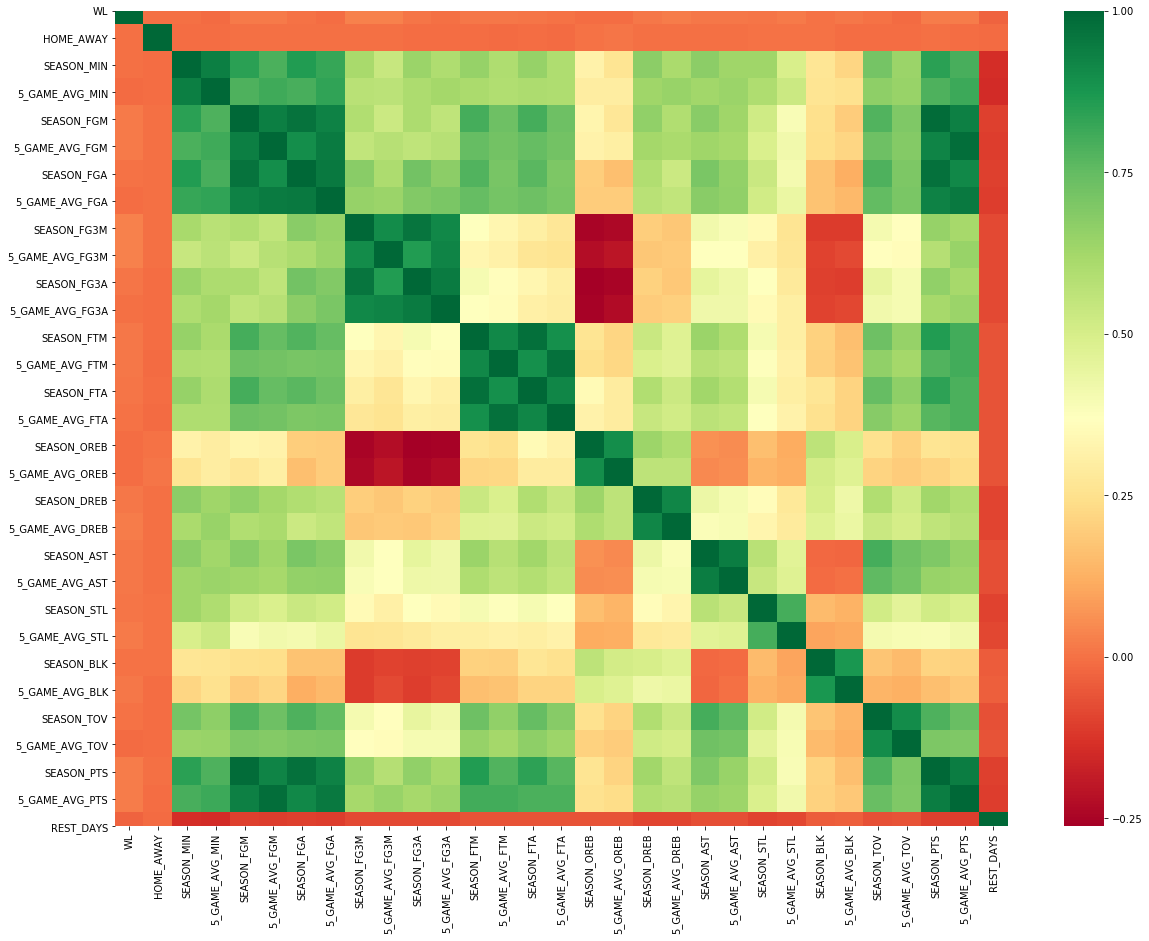

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(20,15))
sns.heatmap(X.corr(), cmap="RdYlGn")

In [72]:
X.columns

Index(['WL', 'HOME_AWAY', 'SEASON_MIN', '5_GAME_AVG_MIN', 'SEASON_FGM',
       '5_GAME_AVG_FGM', 'SEASON_FGA', '5_GAME_AVG_FGA', 'SEASON_FG3M',
       '5_GAME_AVG_FG3M', 'SEASON_FG3A', '5_GAME_AVG_FG3A', 'SEASON_FTM',
       '5_GAME_AVG_FTM', 'SEASON_FTA', '5_GAME_AVG_FTA', 'SEASON_OREB',
       '5_GAME_AVG_OREB', 'SEASON_DREB', '5_GAME_AVG_DREB', 'SEASON_AST',
       '5_GAME_AVG_AST', 'SEASON_STL', '5_GAME_AVG_STL', 'SEASON_BLK',
       '5_GAME_AVG_BLK', 'SEASON_TOV', '5_GAME_AVG_TOV', 'SEASON_PTS',
       '5_GAME_AVG_PTS', 'REST_DAYS', 'PACE_x', 'PACE_y', 'TURN_OVERS',
       'DEF_RATING'],
      dtype='object')

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Scale data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [74]:
# #############################################################################
# Random Forest - performs the best compared to the below models

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, min_samples_leaf = 3,  random_state = 0, n_jobs = -1, min_samples_split = 2) 
regressor.fit(X_train, y_train)
pred = regressor.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('R2 Score:', metrics.r2_score(y_test, pred))

Mean Squared Error: 97.44903881251469
R2 Score: 0.5674827868502018


In [76]:
X_test

array([[ 1.00806558, -1.00344868,  0.94270703, ...,  1.51165874,
         0.91991108, -1.13572778],
       [-0.99199896,  0.99656317, -1.40115637, ...,  0.35312809,
        -0.44581644, -1.46095294],
       [-0.99199896, -1.00344868, -0.86309714, ...,  0.25238629,
         0.52970322,  0.62048811],
       ...,
       [-0.99199896, -1.00344868,  0.69811644, ..., -1.10762795,
        -0.25071251, -0.22509732],
       [-0.99199896,  0.99656317,  0.44861337, ...,  0.65535347,
        -0.93357626,  1.40102851],
       [-0.99199896, -1.00344868, -0.39409026, ...,  0.80646617,
         1.79787877,  0.29526295]])

In [45]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [46]:
# #############################################################################
# Linear Regression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
pred_test_lr= lr.predict(X_test)
print(mean_squared_error(y_test,pred_test_lr))
print(r2_score(y_test, pred_test_lr))

99.24782973702335
0.5594990442993443


In [85]:
# #############################################################################
# Ridge Regression

rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 

pred_test_rr= rr.predict(X_test)
print(mean_squared_error(y_test,pred_test_rr)) 
print(r2_score(y_test, pred_test_rr))

99.2478158659015
0.559499105864846


In [86]:
# #############################################################################
# Lasso Regression

model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 

pred_test_lasso= model_lasso.predict(X_test)
print(mean_squared_error(y_test,pred_test_lasso))
print(r2_score(y_test, pred_test_lasso))

99.3152042246728
0.5592000097886849


In [87]:
# #############################################################################
# ElasticNet (both Lasso and Ridge) Regression

model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_train, y_train) 

pred_test_enet= model_enet.predict(X_test)
print(mean_squared_error(y_test,pred_test_enet))
print(r2_score(y_test, pred_test_enet))

99.30508036283578
0.5592449434746547


C:\Users\chelt\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 693.7291838270612, tolerance: 288.7521056833831
  positive)


In [52]:
# #############################################################################
# SVR

from sklearn.svm import SVR

In [53]:
regr = SVR(kernel = 'rbf', degree = 3)

In [54]:
regr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [55]:
pred = regr.predict(X_test)

In [57]:
print(mean_squared_error(y_test,pred))
print(r2_score(y_test, pred))

100.86988391573222
0.5522997290315672


In [58]:
# #############################################################################
# KNeighbors Regression

from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=15)
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')

In [59]:
pred = neigh.predict(X_test)

In [61]:
print(mean_squared_error(y_test,pred))
print(r2_score(y_test, pred))

103.7964569733442
0.5393104452132534


<h3>Today's Players Selection and Pricing Incorporation

In [99]:
# csv files downloaded directly from Draftkings lineups website
df1 = pd.read_csv('C:/Users/chelt/Downloads/DK_5_5.csv')

In [100]:
# add AvgPointsPerGame to drop list for actual product
df1 = df1.drop(['Position', 'Name + ID', 'ID', 'Game Info', 'TeamAbbrev'], axis = 1)

In [101]:
for i in ['PG', 'SG', 'SF', 'PF', 'C']:
     df1[i] = df1.apply(lambda row: 1 if i in row['Roster Position'] else 0, axis = 1)

In [102]:
df1['G'] = df1.apply(lambda row: 1 if ((row['PG'] == 1) or (row['SG'] == 1)) else 0, axis = 1)
df1['F'] = df1.apply(lambda row: 1 if ((row['SF'] == 1) or (row['PF'] == 1)) else 0, axis = 1)
df1['UTIL'] = 1
df1 = df1.drop(['Roster Position'], axis = 1)
df1.head()

,Name,Salary,AvgPointsPerGame,PG,SG,SF,PF,C,G,F,UTIL
0,Russell Westbrook,11000,57.30,1,0,0,0,0,1,0,1
1,Giannis Antetokounmpo,10900,56.34,0,0,0,1,1,0,1,1
2,Nikola Jokic,10700,57.93,0,0,0,0,1,0,0,1
3,Domantas Sabonis,10600,47.97,0,0,0,1,1,0,1,1
4,Karl-Anthony Towns,10300,50.01,0,0,0,0,1,0,0,1


In [66]:
# Take active players df and rename name column

active_players = active_players.rename(columns={'DISPLAY_FIRST_LAST': 'Name'})
active_players.head()

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,Name,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
10,1630173,"Achiuwa, Precious",Precious Achiuwa,1,2020,2020,precious_achiuwa,1610612748,Miami,Heat,MIA,heat,Y,00
19,1629121,"Adams, Jaylen",Jaylen Adams,0,2018,2020,jaylen_adams,0,,,,,Y,01
22,203500,"Adams, Steven",Steven Adams,1,2013,2020,steven_adams,1610612740,New Orleans,Pelicans,NOP,pelicans,Y,00
24,1628389,"Adebayo, Bam",Bam Adebayo,1,2017,2020,bam_adebayo,1610612748,Miami,Heat,MIA,heat,Y,00
42,200746,"Aldridge, LaMarcus",LaMarcus Aldridge,0,2006,2020,lamarcus_aldridge,0,,,,,Y,00


In [67]:
# Take every dataframe of each player playing on a certain date -> named by player_id
# Predict their draftkings score from each dataframe
# Create a dataframe consisting of player_id & their predictions
# Merge with the draftkings dataframe
# Optimize

result = df1.merge(active_players, on='Name', how='left')
result.head()

,Name,Salary,AvgPointsPerGame,PG,SG,SF,PF,C,G,F,...,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
0,Russell Westbrook,11000,57.30,1,0,0,0,0,1,0,...,2008,2020,russell_westbrook,1.610613e+09,Washington,Wizards,WAS,wizards,Y,00
1,Giannis Antetokounmpo,10900,56.34,0,0,0,1,1,0,1,...,2013,2020,giannis_antetokounmpo,1.610613e+09,Milwaukee,Bucks,MIL,bucks,Y,00
2,Nikola Jokic,10700,57.93,0,0,0,0,1,0,0,...,2015,2020,nikola_jokic,1.610613e+09,Denver,Nuggets,DEN,nuggets,Y,00
3,Domantas Sabonis,10600,47.97,0,0,0,1,1,0,1,...,2016,2020,domantas_sabonis,1.610613e+09,Indiana,Pacers,IND,pacers,Y,00
4,Karl-Anthony Towns,10300,50.01,0,0,0,0,1,0,0,...,2015,2020,karl-anthony_towns,1.610613e+09,Minnesota,Timberwolves,MIN,timberwolves,Y,00


In [82]:
# Create new dataframe for DK score predictions
# Dataframe with player_id of players playing on certain date

pipe = pd.DataFrame(result['PERSON_ID'])
pipe

final_score = pipe.merge(predict_df, on='PERSON_ID', how='left')
final_score = final_score.dropna()
final_score.head()

,PERSON_ID,WL,HOME_AWAY,SEASON_MIN,5_GAME_AVG_MIN,SEASON_FGM,5_GAME_AVG_FGM,SEASON_FGA,5_GAME_AVG_FGA,SEASON_FG3M,...,SEASON_TOV,5_GAME_AVG_TOV,SEASON_PTS,5_GAME_AVG_PTS,REST_DAYS,PACE_x,PACE_y,TURN_OVERS,DEF_RATING,DKING_SCORE
0,201566.0,0.0,1,35.9661,38.2,8.35593,9.2,18.8136,17.2,1.22034,...,4.86441,3,21.9153,23.6,1.0,106.3,101.7,12.0,76.0,63.25
1,203507.0,1.0,0,33.1273,29.2,10.3273,10.8,18.3636,20.4,1.18182,...,3.56364,2.4,28.4909,29.2,1.0,104.2,106.3,12.5,77.0,47.25
2,203999.0,0.0,0,35.0615,32.6,10.2462,9.4,18.1538,18,1.38462,...,3.10769,3,26.3231,27.4,2.0,99.3,98.4,12.1,79.4,63.5
3,1627734.0,0.0,0,35.7679,35.8,7.64286,9.2,14.4286,15.4,0.803571,...,3.44643,4.2,20.1429,23,1.0,103.9,99.7,12.0,76.8,55
4,1626157.0,0.0,0,34.2558,34.8,8.5814,8.4,17.6047,18,2.46512,...,3.25581,3.8,24.8372,25.2,4.0,104.1,102.8,11.5,80.0,36


In [83]:
# Perform DK_SCORE predictions with best model -> Random Forest
final_X = final_score.drop(columns = ['PERSON_ID', 'DKING_SCORE'])
final_X = sc_X.transform(final_X)

pred = regressor.predict(final_X)
pred

array([65.54442916, 52.611709  , 59.25787747, 53.31931512, 46.10763052,
       48.49524724, 46.16031246, 44.10282859, 50.94152497, 40.01265043,
       50.29382552, 44.68668785, 49.11775095, 35.82979423, 45.64097573,
       37.23218226, 38.06984649, 34.99601218, 34.47004899, 40.74366039,
       37.58161979, 37.02881266, 36.71152436, 37.54063145, 41.114016  ,
       41.32100782, 35.94757096, 34.03604742, 27.7490882 , 43.78841526,
       27.04028165, 26.53588448, 37.50741948, 35.40300386, 32.25963401,
       39.20351917, 33.55167152, 39.32219231, 29.72006291, 20.6634468 ,
       25.76295985, 34.6116678 , 33.82974328, 31.23334067, 29.60454304,
       31.59311746, 30.8357466 , 28.85697158, 27.87006916, 31.7589396 ,
       30.25528835, 31.40168166, 27.47129465, 24.18527866, 20.23126442,
       30.0331095 , 23.94719517, 27.643444  , 30.74211361, 23.38422653,
       17.31824509, 25.49837854, 23.90094307, 31.03877615, 29.34157547,
       24.06351947, 29.76922098, 21.24526881, 21.63610374, 30.01

In [95]:
# Turn array into dataframe
ff_df = pd.DataFrame(pred, columns = ['DK_PRED'])

# Concate back into final_score to retain PLayer-ID
pred_df = pd.concat([final_score, ff_df], axis=1)

# Get rid of all columns except for PERSON_ID and DK_PRED
cols_to_keep = ['PERSON_ID', 'DK_PRED']
pred_df = pred_df.drop(pred_df.columns.difference(cols_to_keep), axis=1)

# Only 270 players have DK score predicted, NaNs are due to injury or not playing
pred_df = pred_df.dropna()
pred_df

,PERSON_ID,DK_PRED
0,201566.0,65.544429
1,203507.0,52.611709
2,203999.0,59.257877
3,1627734.0,53.319315
4,1626157.0,46.107631
...,...,...
265,1628995.0,8.448350
266,1630192.0,14.521070
267,1628373.0,7.920976
268,1629033.0,5.104897


In [107]:
# Remerge back into draftkings dataframe

f_result = result.merge(pred_df, on='PERSON_ID', how='left')
f_result.head()

,Name,Salary,AvgPointsPerGame,PG,SG,SF,PF,C,G,F,...,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH,DK_PRED
0,Russell Westbrook,11000,57.30,1,0,0,0,0,1,0,...,2020,russell_westbrook,1.610613e+09,Washington,Wizards,WAS,wizards,Y,00,65.544429
1,Giannis Antetokounmpo,10900,56.34,0,0,0,1,1,0,1,...,2020,giannis_antetokounmpo,1.610613e+09,Milwaukee,Bucks,MIL,bucks,Y,00,52.611709
2,Nikola Jokic,10700,57.93,0,0,0,0,1,0,0,...,2020,nikola_jokic,1.610613e+09,Denver,Nuggets,DEN,nuggets,Y,00,59.257877
3,Domantas Sabonis,10600,47.97,0,0,0,1,1,0,1,...,2020,domantas_sabonis,1.610613e+09,Indiana,Pacers,IND,pacers,Y,00,53.319315
4,Karl-Anthony Towns,10300,50.01,0,0,0,0,1,0,0,...,2020,karl-anthony_towns,1.610613e+09,Minnesota,Timberwolves,MIN,timberwolves,Y,00,46.107631


In [108]:
f_result = f_result[['Name', 'Salary', 'AvgPointsPerGame', 'PG', 'SG', 'SF', 'PF', 'C', 'G', 'F', 'UTIL', 'PERSON_ID', 'DK_PRED']]
f_result

,Name,Salary,AvgPointsPerGame,PG,SG,SF,PF,C,G,F,UTIL,PERSON_ID,DK_PRED
0,Russell Westbrook,11000,57.30,1,0,0,0,0,1,0,1,201566.0,65.544429
1,Giannis Antetokounmpo,10900,56.34,0,0,0,1,1,0,1,1,203507.0,52.611709
2,Nikola Jokic,10700,57.93,0,0,0,0,1,0,0,1,203999.0,59.257877
3,Domantas Sabonis,10600,47.97,0,0,0,1,1,0,1,1,1627734.0,53.319315
4,Karl-Anthony Towns,10300,50.01,0,0,0,0,1,0,0,1,1626157.0,46.107631
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,Justin Jackson,3000,13.24,0,0,0,1,0,0,1,1,1628382.0,NaN
300,Jordan Nwora,3000,9.38,0,0,0,1,0,0,1,1,1629670.0,NaN
301,Axel Toupane,3000,4.75,0,1,0,0,0,1,0,1,1626253.0,NaN
302,Isaac Bonga,3000,5.83,0,0,1,0,0,0,1,1,1629067.0,NaN


<h3>Player Selection

In [109]:
people = list(f_result['Name'])

In [110]:
prob = LpProblem("Player Choosing Problem",LpMaximize)

C:\Users\chelt\Anaconda3\lib\site-packages\pulp\pulp.py:1199: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [111]:
list_of_vars = [LpVariable(name, lowBound = 0, upBound = 1, cat = 'Integer') for name in people]

In [112]:
#Objective Func
prob += lpSum([df1.AvgPointsPerGame[i]*list_of_vars[i] for i in range(len(df1))])

In [113]:
#Salary Constraint
prob += sum([df1.Salary[i]*list_of_vars[i] for i in range(len(df1))]) <= 50000
prob += sum([list_of_vars[i] for i in range(len(df1))]) == 8
prob += sum([df1.PG[i]*list_of_vars[i] for i in range(len(df1))]) >= 1
prob += sum([df1.SG[i]*list_of_vars[i] for i in range(len(df1))]) >= 1
prob += sum([df1.SF[i]*list_of_vars[i] for i in range(len(df1))]) >= 1
prob += sum([df1.PF[i]*list_of_vars[i] for i in range(len(df1))]) >= 1
prob += sum([df1.C[i]*list_of_vars[i] for i in range(len(df1))]) >= 1
prob += sum([df1.G[i]*list_of_vars[i] for i in range(len(df1))]) >= 3
prob += sum([df1.F[i]*list_of_vars[i] for i in range(len(df1))]) >= 3

In [114]:
status = prob.solve()

In [115]:
for v in prob.variables ():
    if v.varValue == 1:
        print (v.name, "=", v.varValue)

Giannis_Antetokounmpo = 1.0
Jamal_Murray = 1.0
John_Wall = 1.0
Malik_Beasley = 1.0
Markelle_Fultz = 1.0
Nikola_Jokic = 1.0
Russell_Westbrook = 1.0
T.J._Warren = 1.0
